# GeoPandas AI - Flood Analysis Sample

In this Jupyter Notebook, we propose to perform geospatial analysis of a dataset using GeoPandas AI.

# Initialisation of GeoPandas AI

GeoPandas AI relies on an external AI service, which you can configure through LiteLLM.

In [6]:
import os

import geopandas as gpd
import geopandasai as gai
from folium import Map
from geopandasai import update_geopandasai_config
from matplotlib.figure import Figure

update_geopandasai_config(
    lite_llm_config={
        "model": "vertex_ai/gemini-2.0-flash", # You can change this according to litellm documentation.
        "temperature": 0,  # To be albe to replicate this tutorial, not recommended for real usage
        "vertex_credentials": os.environ.get("VERTEX_CREDENTIALS"),
    }
)

# Data analysis

We will now load the different data files as gdf, convert them to GeoDataFrameAI, to be able to interact with them in Natural Language.

A temperature of 0 is provided to increase the reproductibility of this notebook. However, this is not enough to guarentee that the LLM will produce 100% deterministic results. Therefore, resetting the cache may lead to different outputs.

In [4]:
# gai.reset_cache()

In [7]:
floodedAreas_gdf = gpd.read_file("./Data/Shps/boiseFlood200yr_v4.shp") # gai.read_file(...), would also work and directly instantiate a GeoDataFrameAI
highways_gdf = gpd.read_file("./Data/Shps/primaryHighways.gpkg")
facilities_gdf = gpd.read_file('./Data/Shps/schoolsHospitalsPoliceFire.gpkg')

In [ ]:
floodedAreas = gai.GeoDataFrameAI(floodedAreas_gdf)
highways = gai.GeoDataFrameAI(highways_gdf, description="This dataset contains information about roads.")
facilities = gai.GeoDataFrameAI(facilities_gdf)

In [9]:
floodedAreas.chat("What are the the bounds of the flooded areas.")


[-116.51641689023492, 43.662395732274334, -116.29890456750606, 43.69483302031264]

In [10]:
floodedAreas.chat("Plot the flooded areas.")

In [12]:
highways.chat("Plot the roads.").improve("Add a legend. Roads with the same name should have the same color.").improve(
    "Improve the legend, it does not fit in its box. Make it scrollable.")

In [13]:
facilities.chat("Find unique amenities.")

['school', 'hospital', 'fire_station']

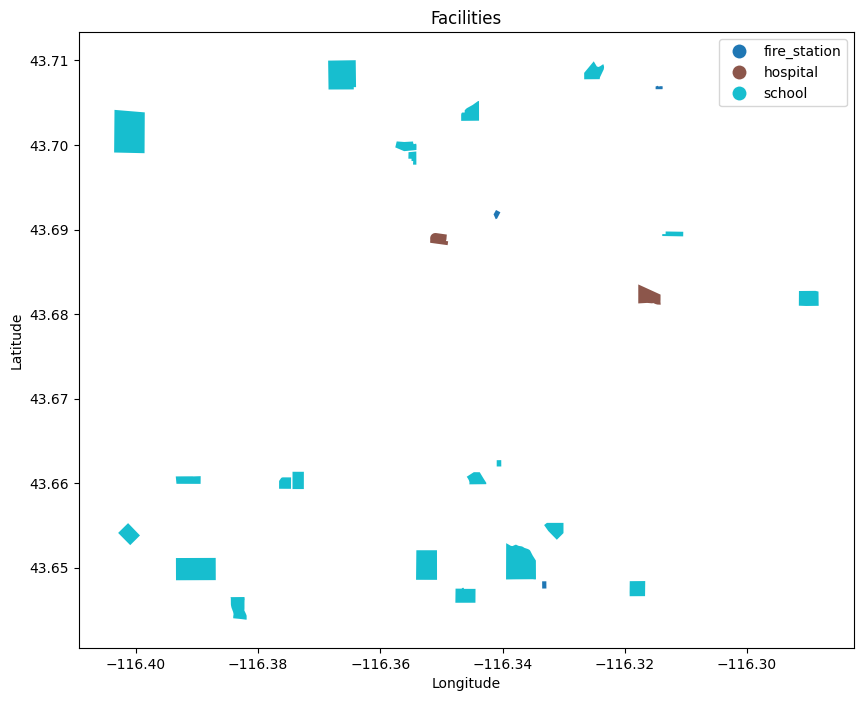

In [14]:
fig = facilities.chat("Plot the facilities.", return_type=Figure)

In [15]:
highways.chat(
    "Plot the highways the schools, and flooded areas.",
    floodedAreas,
    facilities,
    return_type=Map,
).improve("Save in map.html file")

In [16]:
floodedFacilities = facilities.chat(
    "Add a Flooded column to the facilities based on whether they are in the flooded areas",
    floodedAreas,
)


It should be noted, that when GeoPandas-AI returns a GDF or a DF, improve functions cannot yet be "chained" on the same line. If the users need to improve the GDF-AI, they need to do it in a separate expression:

In [17]:
# floodedFacilities = facilities.improve("Keep only the facilities flooded.")

In [18]:
floodedFacilities.chat("Export to the Out/floodedSchools.gpkg. Keep only the facilities flooded.", return_type=None)

amenity                                name  \
9   hospital  Saint Alphonsus Eagle Health Plaza   
20  hospital                                None   

                                             geometry  Flooded  
9   MULTIPOLYGON (((-116.34898 43.68815, -116.3488...     True  
20  MULTIPOLYGON (((-116.31779 43.68126, -116.3163...     True

In [19]:
facilities.inspect()

Prompt 1: Add a Flooded column to the facilities based on whether they are in the flooded areas
Code 1:

import geopandas
import geopandas as gpd

def execute(df_1, df_2) -> geopandas.geodataframe.GeoDataFrame:
    """Add a Flooded column to the facilities based on whether they are in the flooded areas.

    :param df_1: GeoDataFrame containing facilities (e.g., schools, fire stations).
    :type df_1: geopandas.GeoDataFrame
    :param df_2: GeoDataFrame containing flooded areas (polygons).
    :type df_2: geopandas.GeoDataFrame
    :return: GeoDataFrame with an additional 'Flooded' column indicating whether each facility is within a flooded area.
    :rtype: geopandas.geodataframe.GeoDataFrame
    """

    df_1['Flooded'] = df_1.intersects(df_2.unary_union)
    return df_1

--------------------------------------------------------------------------------


In [20]:
facilities.inject("flooded")

Manual injection procedure...
First add, if not already present, the following import statement:
import ai
Then replace the following code with the function call:
ai.flooded(gdf1, gdf2, ...)
Make sure to adjust the function call with the correct parameters.


In [21]:
import ai

ai.flooded(facilities_gdf, floodedAreas_gdf)

amenity                                 name  \
0         school            Pioneer Elementary School   
1         school               Centennial High School   
2         school             Joplin Elementary School   
3         school           Lowell Scott Middle School   
4         school    Cecil D. Andrus Elementary School   
5         school        Eagle Hills Elementary School   
6         school           McMillan Elementary School   
7         school                    Eagle High School   
8         school          Paramount Elementary School   
9       hospital   Saint Alphonsus Eagle Health Plaza   
10        school                                 None   
11        school           Prospect Elementary School   
12        school               Heritage Middle School   
13        school                  Eagle Middle School   
14        school  Rolling Hills Public Charter School   
15        school                   The Ambrose School   
16        school         Seven Oaks Elementary School   
17        school                                 None   
18        school       Shadow Hills Elementary School   
19        school                                 None   
20      hospital                                 None   
21        school                                 None   
22  fire_station               Boise Fire Station #10   
23  fire_station                Eagle Fire Station #1   
24  fire_station                Eagle Fire Station #2   
25        school  Eagle Elementary School of the Arts   

                                             geometry  Flooded  
0   MULTIPOLYGON (((-116.34768 43.64752, -116.3475...    False  
1   MULTIPOLYGON (((-116.3394 43.6529, -116.33894 ...    False  
2   MULTIPOLYGON (((-116.33274 43.6553, -116.33003...    False  
3   MULTIPOLYGON (((-116.35409 43.65206, -116.3539...    False  
4   MULTIPOLYGON (((-116.34585 43.66075, -116.3447...    False  
5   MULTIPOLYGON (((-116.34384 43.70522, -116.3438...    False  
6   MULTIPOLYGON (((-116.31919 43.6484, -116.31665...    False  
7   MULTIPOLYGON (((-116.40347 43.70416, -116.3985...    False  
8   MULTIPOLYGON (((-116.4009 43.65266, -116.40287...    False  
9   MULTIPOLYGON (((-116.34898 43.68815, -116.3488...     True  
10  MULTIPOLYGON (((-116.37458 43.66068, -116.3759...    False  
11  MULTIPOLYGON (((-116.38448 43.64651, -116.3844...    False  
12  MULTIPOLYGON (((-116.39342 43.65114, -116.3869...    False  
13  MULTIPOLYGON (((-116.36846 43.70657, -116.3685...    False  
14  MULTIPOLYGON (((-116.31387 43.68947, -116.3138...    False  
15  MULTIPOLYGON (((-116.37435 43.6593, -116.37435...    False  
16  MULTIPOLYGON (((-116.32409 43.70779, -116.3266...    False  
17  MULTIPOLYGON (((-116.3541 43.69924, -116.35409...    False  
18  MULTIPOLYGON (((-116.29153 43.68099, -116.2915...    False  
19  MULTIPOLYGON (((-116.34095 43.66271, -116.3402...    False  
20  MULTIPOLYGON (((-116.31779 43.68126, -116.3163...     True  
21  MULTIPOLYGON (((-116.39345 43.66079, -116.3933...    False  
22  MULTIPOLYGON (((-116.33351 43.64753, -116.3328...    False  
23  MULTIPOLYGON (((-116.34106 43.69231, -116.3413...    False  
24  MULTIPOLYGON (((-116.31389 43.70696, -116.3138...    False  
25  MULTIPOLYGON (((-116.35754 43.69972, -116.3560...    False